In [1]:
import os
import imageio
import pandas as pd
import datetime as dt
from platform import system
from PIL import Image, ImageFont, ImageDraw

import arcgis
from arcgis.gis import GIS
from arcgis import geometry
from arcgis.raster.functions import apply

In [2]:
gis = GIS("https://www.arcgis.com", "arcgis_python", "P@ssword123")

<Item title:"Multispectral Landsat" type:Imagery Layer owner:esri>
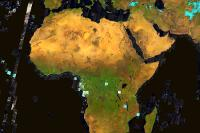

In [3]:
def exact_search(my_gis, title, owner_value, item_type_value):
    final_match = None
    search_result = my_gis.content.search(query= title + ' AND owner:' + owner_value,
                                          item_type=item_type_value,
                                          outside_org=True)
    
    if "Imagery Layer" in item_type_value:
        item_type_value = item_type_value.replace("Imagery Layer", "Image Service")
    elif "Layer" in item_type_value:
        item_type_value = item_type_value.replace("Layer", "Service")
    
    for result in search_result:
        if result.title == title and result.type == item_type_value:
            final_match = result
            break
    return final_match

landsat_item = exact_search(gis, 'Multispectral Landsat', 'esri', 'Imagery Layer')
landsat = landsat_item.layers[0]
landsat_item

In [4]:
rgb_collection = apply(landsat, 'Natural Color with DRA')

In [6]:
m = gis.map('Hirakund reservoir, Odisha', 10)


m

MapView(layout=Layout(height='400px', width='100%'))

In [7]:
extent = m.extent
extent

{'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
 'xmin': 9202564.185655857,
 'ymin': 2397108.3807668495,
 'xmax': 9503420.328986166,
 'ymax': 2519407.6260230723}

In [8]:
def collection(df, interval, start, end, height, width):
    images=[]
    if(interval=='m'):                                                                                     # monthly
        for i in range(int(start.split('-')[0]), int(end.split('-')[0])+1):
            for j in range(1,13):
                selected = df[(df['AcquisitionDate'].dt.year == i) & (df['AcquisitionDate'].dt.month == j)]
                id = selected['OBJECTID'].values.tolist()
                if(len(id)>0):
                    rgb_collection.mosaic_by(method="LockRaster",lock_rasters=id)
                    img_name = 'img_'+str(i)+"-"+str(j)+".jpg"
                    rgb_collection.export_image(bbox=extent, size=[height,width], f='image', 
                                                  save_folder='.', 
                                                  save_file=img_name)
                    img = Image.open(img_name).convert('RGB')
                    if system()=='Windows':
                        font = ImageFont.truetype("arial.ttf", 30)
                    elif system()=='Linux':
                        font = ImageFont.truetype("~/.fonts/truetype/dejavu/DejaVuSans.ttf", 30)
                    else:
                        font = ImageFont.truetype("Arial.ttf", 30)
                    draw = ImageDraw.Draw(img)
                    draw.text((550, 0),str(j)+"-"+str(i),(255,255,255),font=font)
                    images.append(img)
                    os.remove(img_name)
                    
    elif(interval=='y'):                                                                                  # yearly
        for i in range(int(start.split('-')[0]), int(end.split('-')[0])+1):
            selected = df[df['AcquisitionDate'].dt.year == i]
            id = selected['OBJECTID'].values.tolist()
            if(len(id)>0):
                rgb_collection.mosaic_by(method="LockRaster",lock_rasters=id)
                img_name = 'img_'+str(i)+".jpg"
                rgb_collection.export_image(bbox=extent, size=[height,width], f='image', 
                                              save_folder='.', 
                                              save_file=img_name)
                img = Image.open(img_name).convert('RGB')
                if system()=='Windows':
                    font = ImageFont.truetype("arial.ttf", 30)
                elif system()=='Linux':
                    font = ImageFont.truetype("~/.fonts/truetype/dejavu/DejaVuSans.ttf", 30)
                else:
                    font = ImageFont.truetype("Arial.ttf", 30)
                draw = ImageDraw.Draw(img)
                draw.text((550, 0),str(i),(255,255,255),font=font)    
                images.append(img)
                os.remove(img_name)
    
    return images

In [9]:
def create_movie(target, interval, start, end, height, width, extent, duration):
    start_date = dt.datetime.strptime(start, '%Y-%m-%d')
    end_date = dt.datetime.strptime(end, '%Y-%m-%d')
    selected = target.filter_by(where="(Category = 1) AND (CloudCover <=0.5)",
                             time=[start_date, end_date],
                             geometry=arcgis.geometry.filters.intersects(extent))

    df = selected.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear", 
                        order_by_fields="AcquisitionDate").sdf
    df['AcquisitionDate'] = pd.to_datetime(df['AcquisitionDate'], unit='ms')
    frames = collection(df, interval, start, end, height, width)
    imageio.mimsave('movie'+'_'+interval+'.gif', frames, duration=duration)
    print("Movie Created")

In [10]:
create_movie(rgb_collection,'m' ,'2019-01-01','2019-12-31', 1250, 450, extent, 0.4)          # calling create_movie function

Movie Created
